In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from statsmodels.stats.power import NormalIndPower
import math

%matplotlib inline

In [2]:
# Reading test dataset
test = pd.read_csv('test_results.csv')
test.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [3]:
# Check test data type and number of valid instances
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 9 columns):
Unnamed: 0          316800 non-null int64
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 21.8+ MB


#### Looks like we have null values in test. Lets check that

In [47]:
# How many missing values?
test.isna().sum()

Unnamed: 0              0
user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price                   0
converted               0
dtype: int64

#### We have a lot of null values in operative_system. However, no null values in device. Maybe we can only use device as it may not necessarily be useful to now the operating system.

#### We also have a few null values in timestamp and source. Lets keep nulls in the back burner for a sec and look at the user dataset

In [5]:
# Reading users dataset
users = pd.read_csv('user_table.csv')
users.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


#### Lets check for data type and any missing values.

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


#### Even though test dataset and user dataset can be joined in user_id, user dataset has about 41,000 less entries than test. To avoid missing data, I will keep the dataset separated for now.

In [48]:
# Lets go back to the test dataset and take a closer look at it
test.describe()

,Unnamed: 0,user_id,test,price,converted
count,316800.000000,316800.000000,316800.000000,3.168000e+05,316800.000000
mean,158399.500000,499281.341840,0.360079,6.457590e+06,0.018333
std,91452.426977,288591.154044,0.480024,6.797307e+07,0.134154
min,0.000000,3.000000,0.000000,3.900000e+01,0.000000
25%,79199.750000,249525.750000,0.000000,3.900000e+01,0.000000
50%,158399.500000,499021.500000,0.000000,3.900000e+01,0.000000
75%,237599.250000,749025.500000,1.000000,5.900000e+01,0.000000
max,316799.000000,1000000.000000,1.000000,9.998843e+08,1.000000


#### The only values price should have is either 39 or 59. This is clearly not the case. I'll fix that.

In [8]:
# Filter-out values higher than 59
test_price_fix = test.drop(test[test.price > 59.0].index)
len(test_price_fix)

313726

Text(0.5, 0, 'Price')

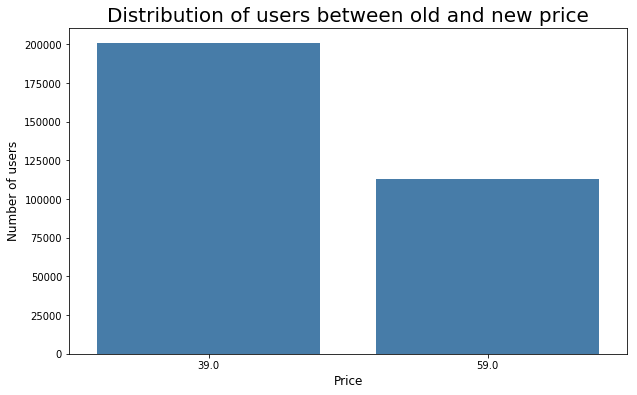

In [79]:
# Lets plot distribution of user between old and new price
plt.figure(figsize=(10,6))
sns.countplot(x='price', data=test_price_fix, color='#377eb8')

plt.title('Distribution of users between old and new price', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Price', fontsize=12)

#### Lets first decide whether we should price out product at 39 dollars or 59 dollars

In [58]:
# Create a new df for old price only users
old_price_users = test_price_fix[test_price_fix.price==39.0]
print('Size of old price users dataset', len(old_price_users))
print('Percent user that saw $39 is', len(old_price_users)/len(test_price_fix)*100)
old_price_users.head()

Size of old price users dataset 200747
Percent user that saw $39 is 63.98800226949631


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0
5,5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0


#### Users the saw 39 dollars price is ~64%

In [11]:
old_price_users.describe()

,Unnamed: 0,user_id,test,price,converted
count,200747.000000,200747.000000,200747.000000,200747.0,200747.000000
mean,158306.167479,499176.185388,0.000767,39.0,0.019876
std,91383.871761,288614.930529,0.027687,0.0,0.139574
min,0.000000,9.000000,0.000000,39.0,0.000000
25%,79244.500000,249508.000000,0.000000,39.0,0.000000
50%,158333.000000,498572.000000,0.000000,39.0,0.000000
75%,237310.500000,749028.000000,0.000000,39.0,0.000000
max,316798.000000,1000000.000000,1.000000,39.0,1.000000


In [59]:
new_price_users = test_price_fix[test_price_fix.price==59.0]
print('Size of new price dataset:', len(new_price_users))
print('Percent user that saw $59 is', len(new_price_users)/len(test_price_fix)*100)
new_price_users.head()

Size of new price dataset: 112979
Percent user that saw $59 is 36.01199773050369


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
7,7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1
8,8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59.0,0
9,9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59.0,0
15,15,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59.0,0


#### Some quick math shows, users exposed to 59 dollars price is ~36%

In [13]:
new_price_users.describe()

,Unnamed: 0,user_id,test,price,converted
count,112979.000000,112979.000000,112979.000000,112979.0,112979.000000
mean,158588.064490,499550.455138,0.998150,59.0,0.015569
std,91568.422897,288598.056417,0.042971,0.0,0.123802
min,3.000000,3.000000,0.000000,59.0,0.000000
25%,79150.500000,249461.500000,1.000000,59.0,0.000000
50%,158550.000000,500175.000000,1.000000,59.0,0.000000
75%,238141.500000,749170.500000,1.000000,59.0,0.000000
max,316799.000000,999995.000000,1.000000,59.0,1.000000


Converted users Counter({0: 196757, 1: 3990})


Text(0.5, 0, 'Converted')

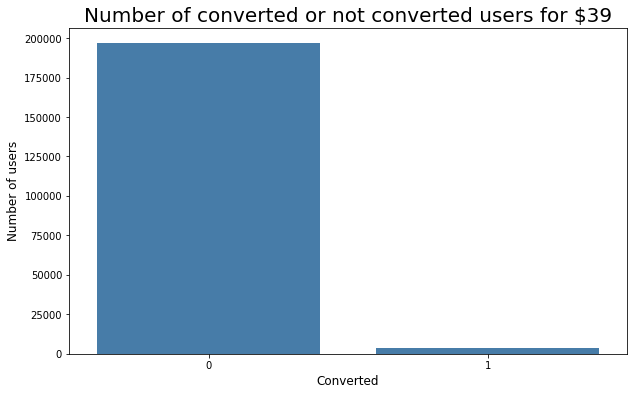

In [78]:
# old price converted users
plt.figure(figsize=(10,6))
sns.countplot(x='converted', data=old_price_users, color='#377eb8')
print('Converted users',Counter(old_price_users.converted))

plt.title('Number of converted or not converted users for $39', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Converted', fontsize=12)

In [68]:
# Percent of converted users how saw old price
print('Percent of converted users at $39:', (Counter(old_price_users.converted)[1]/len(old_price_users))*100,'%')

Percent of converted users at $39: 1.9875764021380145 %


#### About 1.99% of users who see 39 dollars price are converted

Converted users Counter({0: 111220, 1: 1759})


Text(0.5, 0, 'Converted')

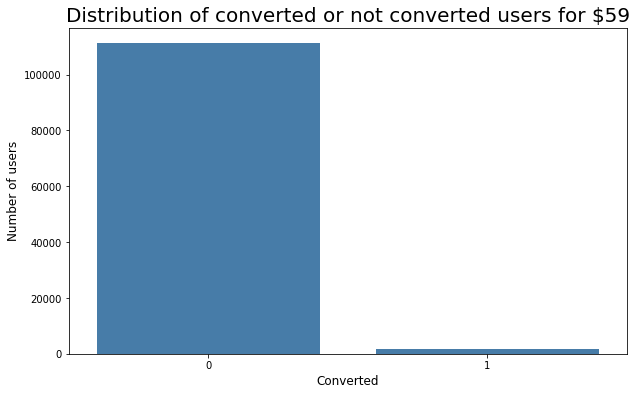

In [77]:
# new price converted users
plt.figure(figsize=(10,6))
sns.countplot(x='converted', data=new_price_users, color='#377eb8')
print('Converted users', Counter(new_price_users.converted))

plt.title('Distribution of converted or not converted users for $59', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Converted', fontsize=12)

In [70]:
# Percent of converted users who saw new price
print('Percent of converted users at $59:', (Counter(new_price_users.converted)[1]/len(new_price_users))*100, '%')

Percent of converted users at $59: 1.5569265084661752 %


#### About 1.56% of users who see 59 dollars price are converted.

# Should XYZ price the product at 39 or 59 dollars?

#### First, by incresing the price the conversion rate dropped from ~2% to ~1.56%. This could be a significant drop.

#### However, the expected value from selling the product at 59 would be $0.9204==(New Price*Conversion Rate = $59*0.0156) for every person that goes to the website vs $0.7761==(Old Price*Conversion Rate = $39 * 0.0199) for selling the product at 39.

#### That is an increase of $0.1443 by just selling the product at 59.

#### Therefore, I will recommend XYZ to keep the new price and focus on increasing conversion rate.

#### User_id table is missing about 40k entires. I will start looking at the test dataset by itself and do customer segmentation using Source, timestamp, and device with a focus on conversion rate to find ways to increase customer conversion.

#### Since customer behavior from customers that bought at 39 dollars may be different from customers that bough at 59 dollars, I'll do this anaysis for new price (59) cutomers only

In [71]:
# df for converted users only who saw new price
converted_new_price = new_price_users[new_price_users.converted==1]

In [19]:
# How are users segmented by source that led to buying the product
converted_source_group = converted_new_price.groupby('source')['converted'].count()
converted_source_group

source
ads-bing            78
ads-google         418
ads-yahoo           31
ads_facebook       321
ads_other          130
direct_traffic     218
friend_referral    251
seo-bing            11
seo-google         128
seo-other           42
seo-yahoo           26
seo_facebook       104
Name: converted, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

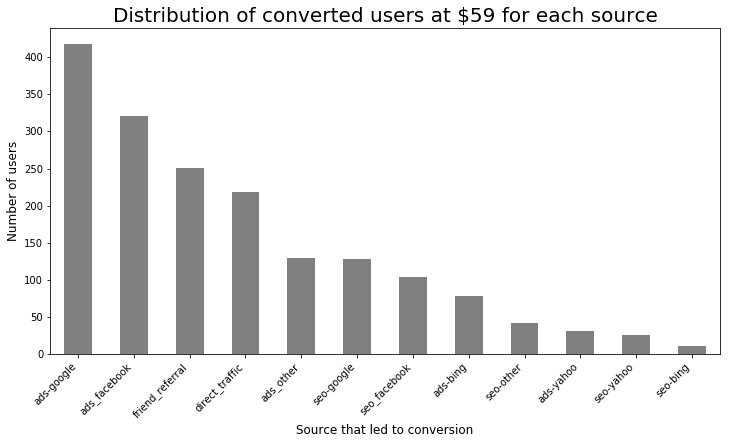

In [81]:
# Plot converted user by source for new price
converted_source_group.sort_values(ascending=False).plot(kind='bar', figsize=(12,6), color='gray')

plt.title('Distribution of converted users at $59 for each source', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Source that led to conversion', fontsize=12)
plt.xticks(rotation=45, ha='right')

#### Looks like user that buy the product come most often from ads in google, then ads in facebok. Rhis is followed by friend referral and direct traffic (probably linked)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

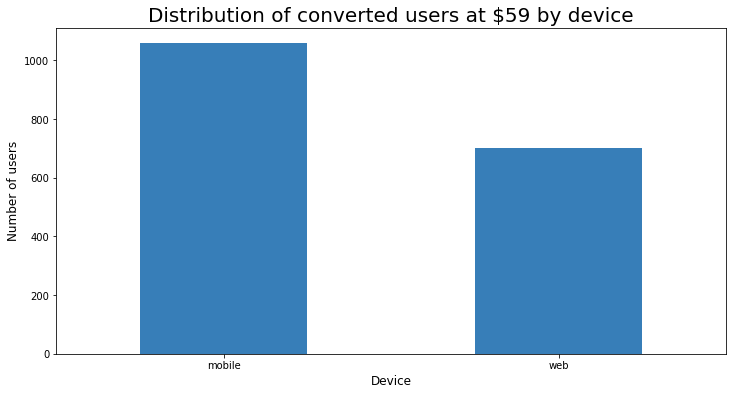

In [82]:
converted_device_group = converted_new_price.groupby('device')['converted'].count()
converted_device_group.plot(kind='bar', figsize=(12,6), color='#377eb8')

plt.title('Distribution of converted users at $59 by device', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Device', fontsize=12)
plt.xticks(rotation='horizontal')

#### Similar to trends in customers behavior users bought the product more often from mobile than traditional computers

#### At what time of the day did users coverted the highest?

In [83]:
# Revisiting the df
converted_new_price.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
7,7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1
46,46,733130,2015-03-14 10:24:22,ads_other,mobile,android,1,59.0,1
355,355,551940,2015-05-26 14:19:16,seo-bing,mobile,iOS,1,59.0,1
481,481,66514,2015-05-04 09:22:36,ads_facebook,web,windows,1,59.0,1
1264,1264,613138,2015-04-14 12:46:49,ads-google,web,windows,1,59.0,1


In [23]:
# To do this, lets split time stamp and keep hour only
time_converted_new_price = converted_new_price.timestamp.str.split(expand=True)[1]
hour_converted_new_price = time_converted_new_price.str.split(':', expand=True)
hour_converted_new_price.head()

,0,1,2
7,08,19,29
46,10,24,22
355,14,19,16
481,09,22,36
1264,12,46,49


In [84]:
# adding hour to the df
converted_new_price['timeStamp_hour'] = hour_converted_new_price[0]
converted_new_price.head()

C:\Users\Jason Sosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,timeStamp_hour
7,7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1,08
46,46,733130,2015-03-14 10:24:22,ads_other,mobile,android,1,59.0,1,10
355,355,551940,2015-05-26 14:19:16,seo-bing,mobile,iOS,1,59.0,1,14
481,481,66514,2015-05-04 09:22:36,ads_facebook,web,windows,1,59.0,1,09
1264,1264,613138,2015-04-14 12:46:49,ads-google,web,windows,1,59.0,1,12


In [25]:
# Grouping by hour
converted_hour_group = converted_new_price.groupby('timeStamp_hour')['converted'].count()
converted_hour_group

timeStamp_hour
00     29
01     30
02     36
03     29
04     38
05     25
06     36
07     64
08    112
09    105
10    144
11    189
12    227
13     92
14     87
15     86
16     91
17     83
18    111
19     37
20     29
21     27
22     31
23     20
Name: converted, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

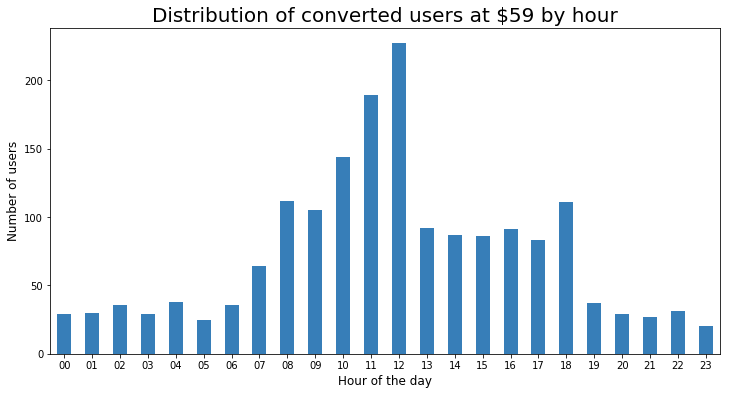

In [89]:
# Plot converted user by source for new price
converted_hour_group.plot(kind='bar', figsize=(12,6), color='#377eb8')

plt.title('Distribution of converted users at $59 by hour', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Hour of the day', fontsize=12)
plt.xticks(rotation='horizontal')

#### This shows that users are converted at the highest rate between 10AM and 1PM

#### Lets take a look at customer segmentation by city and country.

In [27]:
# Time to join the datasets in user_id
user_test_converted_new = converted_new_price.merge(right=users, on='user_id')
user_test_converted_new.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,timeStamp_hour,city,country,lat,long
0,7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1,08,East Orange,USA,40.77,-74.21
1,46,733130,2015-03-14 10:24:22,ads_other,mobile,android,1,59.0,1,10,Charleston,USA,38.35,-81.63
2,355,551940,2015-05-26 14:19:16,seo-bing,mobile,iOS,1,59.0,1,14,Largo,USA,27.91,-82.78
3,481,66514,2015-05-04 09:22:36,ads_facebook,web,windows,1,59.0,1,09,Seattle,USA,47.62,-122.35
4,1264,613138,2015-04-14 12:46:49,ads-google,web,windows,1,59.0,1,12,Surprise,USA,33.66,-112.47


In [28]:
len(user_test_converted_new)

1521

#### As expected the number of subscribed user data decrease after joining the sets.

In [29]:
# Is there more than one country in the dataset?
user_test_converted_new.country.unique()

array(['USA'], dtype=object)

#### Just one Country, lets move into customer ssegmenttion by state.

In [30]:
city_new_converted = user_test_converted_new.groupby('city')['converted'].count()
city_new_converted.head()

city
Abilene        1
Akron          1
Albany         1
Alexandria     1
Aliso Viejo    2
Name: converted, dtype: int64

#### It looks like customers are all over USA. Lets take a look at the top 35 states.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

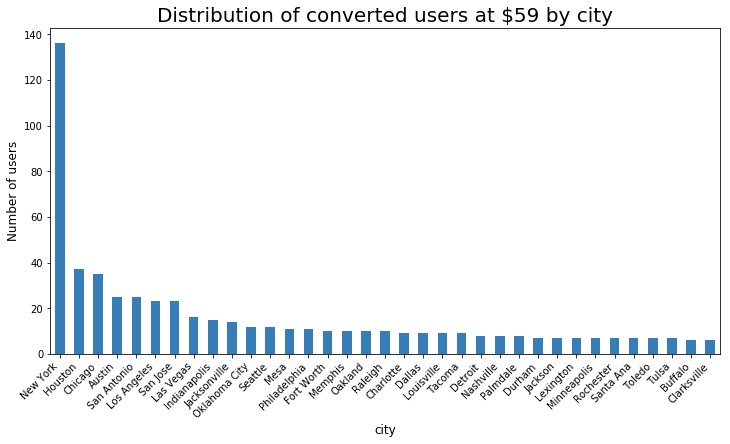

In [101]:
city_new_converted.nlargest(35).plot(kind='bar', figsize=(12,6), color='#377eb8')

plt.title('Distribution of converted users at $59 by city', fontsize=20)
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation=45, ha='right')

#### Higest number of subscribers are from NY, TX, and CA.

In [32]:
# what's the sourve of conversion by state
city_source_new_converted = user_test_converted_new.groupby(['city', 'source'])['converted'].count()
city_source_new_converted.head()

city         source      
Abilene      ads-bing        1
Akron        seo_facebook    1
Albany       ads-yahoo       1
Alexandria   ads_other       1
Aliso Viejo  ads_facebook    2
Name: converted, dtype: int64

In [100]:
city_source_new_converted.nlargest(35)

city           source         
New York       ads-google         33
               friend_referral    19
               ads_facebook       17
               direct_traffic     17
               ads_other          15
               seo_facebook       11
Chicago        ads-google          9
New York       ads-bing            9
               seo-google          9
Austin         ads_facebook        8
San Antonio    ads_facebook        7
Chicago        seo-google          6
Houston        ads-google          6
               ads_facebook        6
San Antonio    ads-google          6
San Jose       ads_facebook        6
Austin         friend_referral     5
Chicago        ads_facebook        5
Houston        ads-bing            5
               direct_traffic      5
Indianapolis   ads-google          5
Lancaster      ads-google          5
Los Angeles    ads-google          5
Memphis        ads-google          5
Oklahoma City  ads-google          5
Philadelphia   ads-google          5
Chicago

#### As expected, the highest source for conversion are google and facebook ads as well as friend referral and direct traffic.

In [34]:
# At what hours of the day they convert the most?
city_hour_new_converted = user_test_converted_new.groupby(['city', 'timeStamp_hour'])['converted'].count()
city_hour_new_converted.head()

city         timeStamp_hour
Abilene      10                1
Akron        16                1
Albany       02                1
Alexandria   15                1
Aliso Viejo  12                1
Name: converted, dtype: int64

In [35]:
city_hour_new_converted.nlargest(35)

city          timeStamp_hour
New York      12                18
              10                15
              17                10
              11                 9
              16                 9
              09                 8
              15                 8
Houston       18                 7
New York      08                 7
              18                 6
San Jose      12                 6
Chicago       09                 5
              11                 5
              12                 5
New York      14                 5
Chicago       08                 4
Houston       10                 4
              15                 4
Indianapolis  11                 4
Los Angeles   08                 4
New York      00                 4
              22                 4
San Antonio   12                 4
Austin        11                 3
              14                 3
Chicago       13                 3
              14                 3
Houston       11          

#### As expected, users convert the hoghest between 10AM and 1PM.

# How can XYZ increase user conversion?

#### The highest number of converted users come from Google and Facebook ads, as well as Friend referral and Direct traffic (maybe linked). Lowest number of converted users come from seo-bing as well as ads and seo in yahoo.

#### Users converted the higest between 10AM and 1PM.

# I recommend XYZ to invest more in ads at Facebook and Google as well as finding ways to increase referrals.
#### Since most converted users use mobile devices, maybe XYZ can give a few dollars away to an app store (sponsored by app owner).
# Additionally, if there are ways to focus ads in a specific region, XYZ should focus on NY, TX, and CA as customers come more often from those states. 

In [36]:
# revisiting df for old price users
old_price_users.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0
5,5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0


#### Should they have stop the test earlier?

In [37]:
# Using timestamp we can check how long did the test ran. Lets make that column
date_old_price = old_price_users.timestamp.str.split('-', expand=True)
old_price_users['year'] = date_old_price[0]
old_price_users['month'] = date_old_price[1]
old_price_users.head()

C:\Users\Jason Sosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jason Sosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,year,month
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,2015,05
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,2015,05
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,2015,04
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,2015,05
5,5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0,2015,04


In [38]:
# For how long did the test ran?
old_price_users.month.unique()

array(['05', '04', '03', nan], dtype=object)

#### The test ran for 3 months

In [39]:
# revisiting df for new price users
new_price_users.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
7,7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1
8,8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59.0,0
9,9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59.0,0
15,15,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59.0,0


In [40]:
# Making a month column
date_new_price = new_price_users.timestamp.str.split('-', expand=True)
new_price_users['year'] = date_new_price[0]
new_price_users['month'] = date_new_price[1]
new_price_users.head()

C:\Users\Jason Sosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jason Sosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,year,month
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,2015,05
7,7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1,2015,03
8,8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59.0,0,2015,03
9,9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59.0,0,2015,04
15,15,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59.0,0,2015,03


In [41]:
new_price_users.month.unique()

array(['05', '03', '04', nan], dtype=object)

#### 39 dollars and 59 dollars test was running at the same time.

In [42]:
# What effect size resulted form the test?
old_price_mean = old_price_users.converted.mean()
old_price_std = old_price_users.converted.std()
new_price_mean = new_price_users.converted.mean()
new_price_std = new_price_users.converted.std()

cohen_d = ((old_price_mean-new_price_mean)/math.sqrt((old_price_std**2+new_price_std**2)/2))
print('Effect size:', cohen_d)

Effect size: 0.03264381956043153


#### I'll do a power analysis using a z-test to find the minimal number of samples needed to detect that effect size (0.033) with a power of 0.8 and alpha of 0.05

In [44]:
alpha = 0.05
power = 0.8
power_analysis = NormalIndPower()
sample_size_z_test = power_analysis.solve_power(effect_size=cohen_d, alpha=alpha, power=power, ratio=0.3, alternative='two-sided')
print('Minimal number of samples neeeded:',sample_size_z_test)

Minimal number of samples neeeded: 31917.34596918271


#### what percentage of the dataset is ~31917 samples?

In [104]:
percent_dataset = (sample_size_z_test/(len(old_price_users)+len(new_price_users)))*100
print('Minimal percent of dataset:', percent_dataset)

Minimal percent of dataset: 10.173637495516058


#### Since test ran for 3 months == 90 days. The test should have been stopped at ~10.2% of 90 days

In [105]:
print ('Minimal length of test in days:', 90*percent_dataset/100)

Minimal length of test in days: 9.156273745964452


#### As management suspected the test didn't have to run for 90 days. In fact, it could have been stopped after 9.2 days (round to 10 days)